In [1]:
!pip install tensorflow

In [2]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
import tensorflow as tf

### Importing the dataset

In [ ]:
#defining path and splitting data into training and validation split
from tensorflow.keras.preprocessing import image_dataset_from_directory
dataset = r"C:\Users\KIIT\Desktop\Blood Cell Classification\BloodCellDetection\blood cell images dataset\bloodcells_dataset"
# Load and split dataset
train_ds = image_dataset_from_directory(
    dataset,                # path to main folder
    validation_split=0.2,         # 20% for validation
    subset="training",
    seed=123,                     # for reproducibility
    image_size=(224, 224),        # resize all images
    batch_size=32
)

val_ds = image_dataset_from_directory(
    dataset,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(224, 224),
    batch_size=32
)

# Check class names
print("Class names:", train_ds.class_names)


Found 17092 files belonging to 8 classes.
Using 13674 files for training.
Found 17092 files belonging to 8 classes.
Using 3418 files for validation.
Class names: ['basophil', 'eosinophil', 'erythroblast', 'ig', 'lymphocyte', 'monocyte', 'neutrophil', 'platelet']


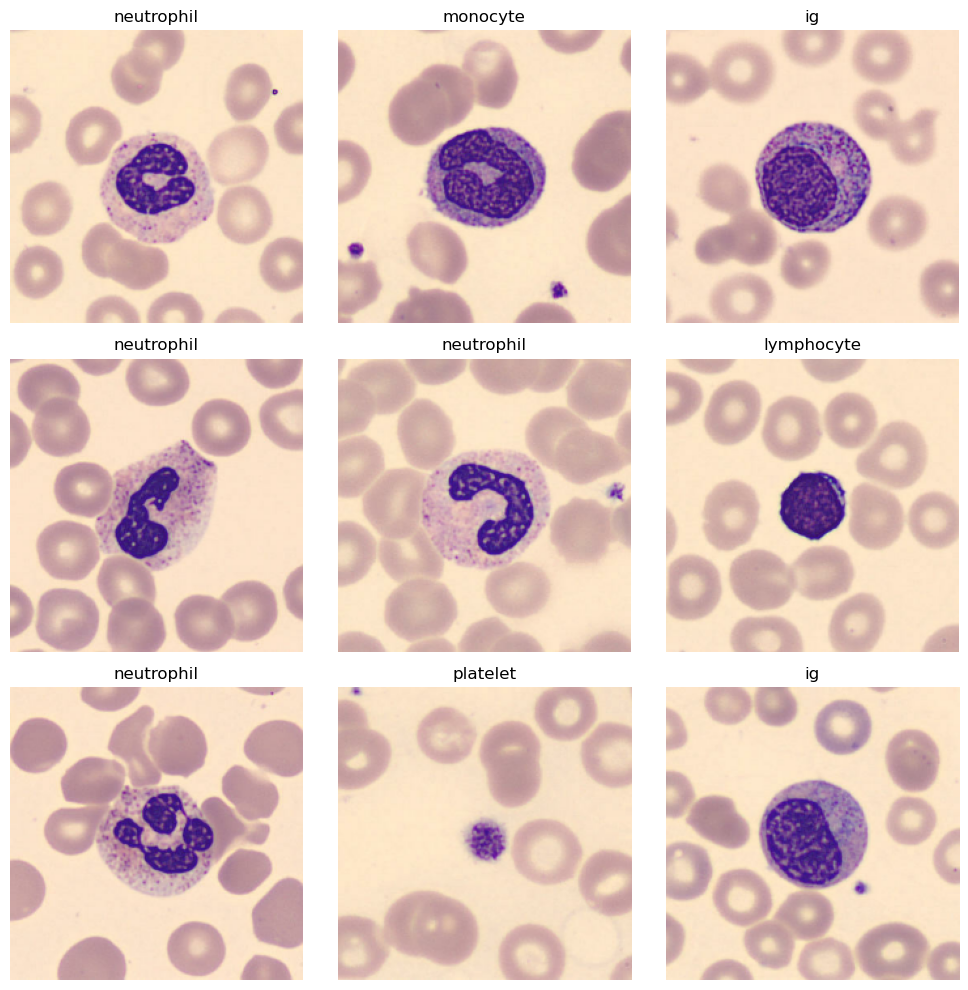

In [4]:
import matplotlib.pyplot as plt

class_names = train_ds.class_names  #to ensure availability

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1): #one batch
    for i in range(9):                  #display 9 images
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.tight_layout()
plt.show()


In [5]:
#further preprocessing to increase instances of images
#data augmentation
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

image = Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(height_factor=(-0.2,-0.3),width_factor=(-0.2,-0.3),interpolation='bilinear'),
        layers.RandomContrast(factor=0.1),
        layers.RandomTranslation(height_factor=0.1,width_factor=0.1),
    ],
    name = "image",
)

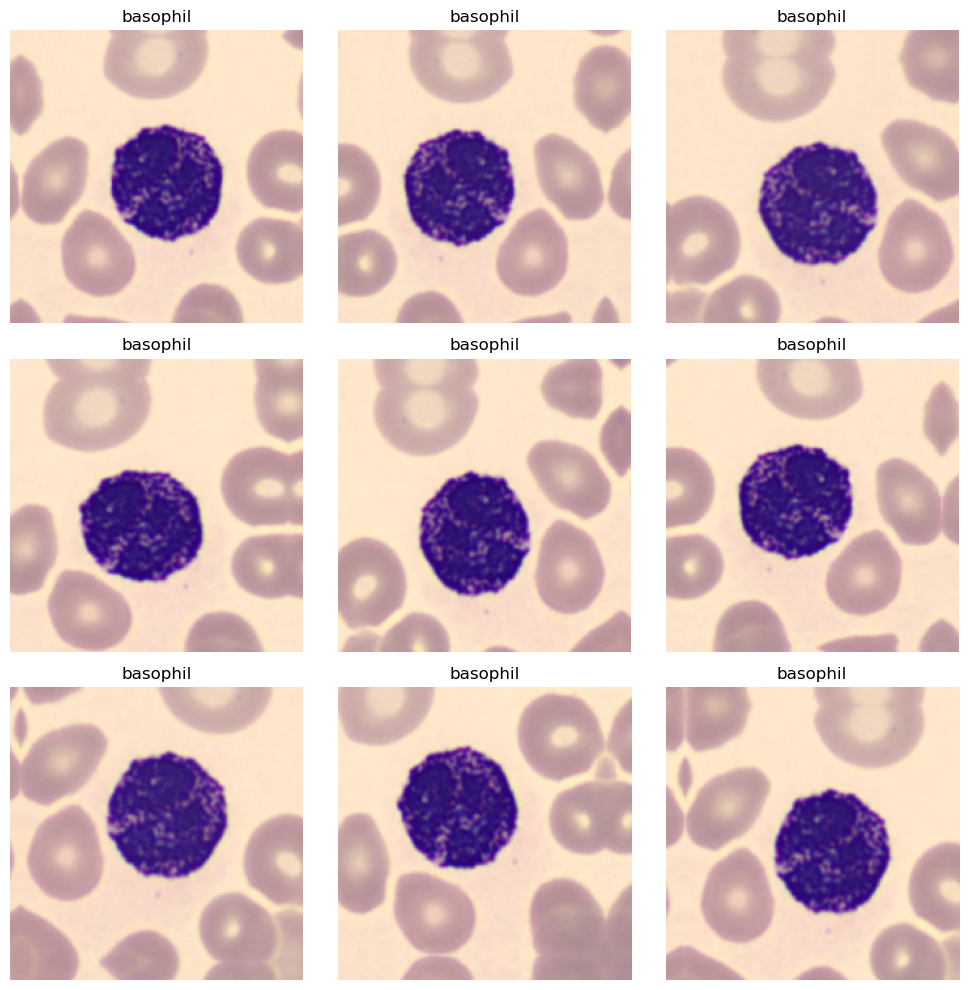

In [6]:
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]

    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = image(tf.expand_dims(first_image, 0), training=True)
        plt.imshow(augmented_image[0].numpy().astype("uint8"))
        plt.title(class_names[labels[0].numpy()])
        plt.axis("off")

plt.tight_layout()
plt.show()


In [23]:
NUM_CLASSES= len(class_names)

In [26]:
#normalize and parallel processing
AUTOTUNE = tf.data.AUTOTUNE

def normalize(image, label):
    image = tf.cast(image, tf.float32) / 255.0  # normalize pixel values
    return image, label

train_ds = train_ds.map(normalize, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(normalize, num_parallel_calls=AUTOTUNE)

train_ds = train_ds.prefetch(AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)

In [11]:
#Neural network
import tensorflow
model = tensorflow.keras.models.Sequential(
    [
        tensorflow.keras.Input(shape=(224,22)),
        tensorflow.keras.layers.Conv2D(32,(3,3),activation='relu'),
        tensorflow.keras.layers.MaxPooling2D((2,2)),
        tensorflow.keras.layers.Dropout(0.2),
        
        tensorflow.keras.layers.Conv2D(64,(3,3),activation='relu'),
        tensorflow.keras.layers.MaxPooling2D((2,2)),
        tensorflow.keras.layers.Dropout(0.2),

        layers.Conv2D(128, (3, 3), activation='relu'),  
        layers.MaxPooling2D(2, 2),
        
        tensorflow.keras.layers.Flatten(),
        tensorflow.keras.layers.Dense(128,activation='relu'),
        tensorflow.keras.layers.Dropout(0.2),
        
        tensorflow.keras.layers.Dense(8,activation='softmax')
    ]
)

In [16]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [17]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 8)                   │           1,032 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,169,992 (42.61 MB)

 Trainable params: 11,169,992 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

es = EarlyStopping(monitor="val_accuracy", min_delta=0.01, patience=10, verbose=1)

model_cp = ModelCheckpoint(
    filepath=r"C:\Users\KIIT\Desktop\Blood Cell Classification\BloodCellDetection\best_model.h5",  # Save as .h5 or .keras
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

In [20]:
#training model
epochs = 25
hist = model.fit(train_ds,epochs=epochs,validation_data=val_ds,callbacks=[model_cp,es],verbose=1)

Epoch 1/25
428/428 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8523 - loss: 0.3992
Epoch 1: val_accuracy improved from 0.81451 to 0.85050, saving model to C:\Users\KIIT\Desktop\Blood Cell Classification\BloodCellDetection\best_model.h5


428/428 ━━━━━━━━━━━━━━━━━━━━ 508s 1s/step - accuracy: 0.8523 - loss: 0.3991 - val_accuracy: 0.8505 - val_loss: 0.4157
Epoch 2/25
428/428 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8761 - loss: 0.3405
Epoch 2: val_accuracy improved from 0.85050 to 0.89760, saving model to C:\Users\KIIT\Desktop\Blood Cell Classification\BloodCellDetection\best_model.h5


428/428 ━━━━━━━━━━━━━━━━━━━━ 506s 1s/step - accuracy: 0.8762 - loss: 0.3404 - val_accuracy: 0.8976 - val_loss: 0.2876
Epoch 3/25
428/428 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9001 - loss: 0.2717
Epoch 3: val_accuracy did not improve from 0.89760
428/428 ━━━━━━━━━━━━━━━━━━━━ 514s 1s/step - accuracy: 0.9001 - loss: 0.2717 - val_accuracy: 0.8338 - val_loss: 0.4621
Epoch 4/25
428/428 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9175 - loss: 0.2326
Epoch 4: val_accuracy improved from 0.89760 to 0.91077, saving model to C:\Users\KIIT\Desktop\Blood Cell Classification\BloodCellDetection\best_model.h5


428/428 ━━━━━━━━━━━━━━━━━━━━ 529s 1s/step - accuracy: 0.9175 - loss: 0.2326 - val_accuracy: 0.9108 - val_loss: 0.2537
Epoch 5/25
428/428 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9282 - loss: 0.2031
Epoch 5: val_accuracy improved from 0.91077 to 0.91369, saving model to C:\Users\KIIT\Desktop\Blood Cell Classification\BloodCellDetection\best_model.h5


428/428 ━━━━━━━━━━━━━━━━━━━━ 532s 1s/step - accuracy: 0.9282 - loss: 0.2031 - val_accuracy: 0.9137 - val_loss: 0.2636
Epoch 6/25
428/428 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9320 - loss: 0.1845
Epoch 6: val_accuracy improved from 0.91369 to 0.91428, saving model to C:\Users\KIIT\Desktop\Blood Cell Classification\BloodCellDetection\best_model.h5


428/428 ━━━━━━━━━━━━━━━━━━━━ 513s 1s/step - accuracy: 0.9320 - loss: 0.1844 - val_accuracy: 0.9143 - val_loss: 0.2701
Epoch 7/25
428/428 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9429 - loss: 0.1548
Epoch 7: val_accuracy improved from 0.91428 to 0.93417, saving model to C:\Users\KIIT\Desktop\Blood Cell Classification\BloodCellDetection\best_model.h5


428/428 ━━━━━━━━━━━━━━━━━━━━ 507s 1s/step - accuracy: 0.9429 - loss: 0.1548 - val_accuracy: 0.9342 - val_loss: 0.2255
Epoch 8/25
428/428 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9500 - loss: 0.1385
Epoch 8: val_accuracy did not improve from 0.93417
428/428 ━━━━━━━━━━━━━━━━━━━━ 501s 1s/step - accuracy: 0.9500 - loss: 0.1385 - val_accuracy: 0.9283 - val_loss: 0.2524
Epoch 9/25
428/428 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9530 - loss: 0.1247
Epoch 9: val_accuracy improved from 0.93417 to 0.94558, saving model to C:\Users\KIIT\Desktop\Blood Cell Classification\BloodCellDetection\best_model.h5


428/428 ━━━━━━━━━━━━━━━━━━━━ 507s 1s/step - accuracy: 0.9530 - loss: 0.1247 - val_accuracy: 0.9456 - val_loss: 0.1973
Epoch 10/25
428/428 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9636 - loss: 0.0957
Epoch 10: val_accuracy did not improve from 0.94558
428/428 ━━━━━━━━━━━━━━━━━━━━ 527s 1s/step - accuracy: 0.9636 - loss: 0.0957 - val_accuracy: 0.9391 - val_loss: 0.2401
Epoch 11/25
428/428 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9654 - loss: 0.0887
Epoch 11: val_accuracy improved from 0.94558 to 0.94705, saving model to C:\Users\KIIT\Desktop\Blood Cell Classification\BloodCellDetection\best_model.h5


428/428 ━━━━━━━━━━━━━━━━━━━━ 556s 1s/step - accuracy: 0.9654 - loss: 0.0887 - val_accuracy: 0.9470 - val_loss: 0.2205
Epoch 12/25
428/428 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9600 - loss: 0.1148
Epoch 12: val_accuracy did not improve from 0.94705
428/428 ━━━━━━━━━━━━━━━━━━━━ 490s 1s/step - accuracy: 0.9600 - loss: 0.1148 - val_accuracy: 0.9441 - val_loss: 0.2347
Epoch 13/25
428/428 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9698 - loss: 0.0873
Epoch 13: val_accuracy did not improve from 0.94705
428/428 ━━━━━━━━━━━━━━━━━━━━ 480s 1s/step - accuracy: 0.9698 - loss: 0.0873 - val_accuracy: 0.9462 - val_loss: 0.2229
Epoch 14/25
428/428 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9696 - loss: 0.0900
Epoch 14: val_accuracy did not improve from 0.94705
428/428 ━━━━━━━━━━━━━━━━━━━━ 461s 1s/step - accuracy: 0.9696 - loss: 0.0900 - val_accuracy: 0.9456 - val_loss: 0.2315
Epoch 15/25
428/428 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9743 - loss: 0.0750
Epoch 15: val_accuracy impro

428/428 ━━━━━━━━━━━━━━━━━━━━ 493s 1s/step - accuracy: 0.9743 - loss: 0.0750 - val_accuracy: 0.9488 - val_loss: 0.2392
Epoch 16/25
428/428 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9743 - loss: 0.0840
Epoch 16: val_accuracy did not improve from 0.94880
428/428 ━━━━━━━━━━━━━━━━━━━━ 516s 1s/step - accuracy: 0.9743 - loss: 0.0839 - val_accuracy: 0.9427 - val_loss: 0.2499
Epoch 17/25
428/428 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9761 - loss: 0.0668
Epoch 17: val_accuracy improved from 0.94880 to 0.94939, saving model to C:\Users\KIIT\Desktop\Blood Cell Classification\BloodCellDetection\best_model.h5


428/428 ━━━━━━━━━━━━━━━━━━━━ 515s 1s/step - accuracy: 0.9761 - loss: 0.0668 - val_accuracy: 0.9494 - val_loss: 0.2291
Epoch 18/25
428/428 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9789 - loss: 0.0566
Epoch 18: val_accuracy improved from 0.94939 to 0.95319, saving model to C:\Users\KIIT\Desktop\Blood Cell Classification\BloodCellDetection\best_model.h5


428/428 ━━━━━━━━━━━━━━━━━━━━ 508s 1s/step - accuracy: 0.9789 - loss: 0.0567 - val_accuracy: 0.9532 - val_loss: 0.2355
Epoch 19/25
428/428 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9802 - loss: 0.0606
Epoch 19: val_accuracy improved from 0.95319 to 0.95436, saving model to C:\Users\KIIT\Desktop\Blood Cell Classification\BloodCellDetection\best_model.h5


428/428 ━━━━━━━━━━━━━━━━━━━━ 507s 1s/step - accuracy: 0.9802 - loss: 0.0607 - val_accuracy: 0.9544 - val_loss: 0.2301
Epoch 19: early stopping


In [21]:
import os
save_path = r"C:\Users\KIIT\Desktop\Blood Cell Classification\BloodCellDetection\best_model.keras"
model.save(save_path)
print(f"Model successfully saved to: {save_path}")

Model successfully saved to: C:\Users\KIIT\Desktop\Blood Cell Classification\BloodCellDetection\best_model.keras


In [30]:
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report
import numpy as np

# Step 1: Load the model
model = load_model("best_model.h5")

# Step 2: Use the same validation data for prediction
raw_val_ds = image_dataset_from_directory(
    dataset,
    validation_split=0.2,   # Ensure same split used as during training
    subset="validation",    # This ensures the correct validation set is used
    seed=123,               # This ensures reproducibility
    image_size=(224, 224),
    batch_size=32
)

# Save class names before applying prefetch
class_names = raw_val_ds.class_names

# Step 3: Prefetch validation data
val_ds = raw_val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

# Step 4: Predict and collect true and predicted labels
y_true = []
y_pred = []

for images, labels in val_ds:
    predictions = model.predict(images)
    y_true.extend(labels.numpy())  # Convert to numpy for sklearn metrics
    y_pred.extend(np.argmax(predictions, axis=1))  # Get predicted class indices

# Step 5: Generate and print the classification report
print(classification_report(y_true, y_pred, target_names=class_names))


Found 17092 files belonging to 8 classes.
Using 3418 files for validation.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

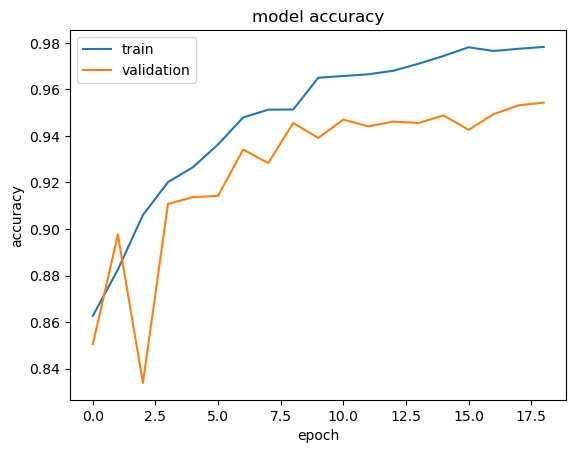

In [35]:
import matplotlib.pyplot as plt
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train","validation"],loc="upper left")
    plt.show()
plot_hist(hist)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted Class: basophil


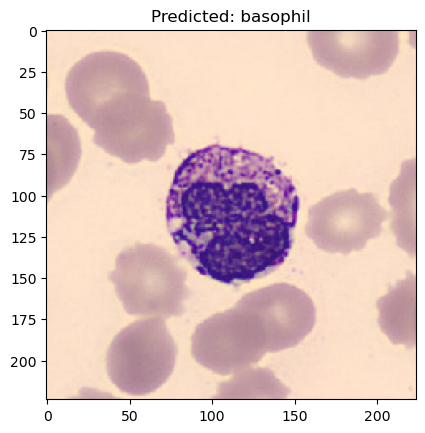

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Load the trained model (make sure the model is saved and the path is correct)
model = tf.keras.models.load_model('best_model.h5')

# Function to preprocess the image and make a prediction
def predict_image(img_path):
    # Load the image with the target size (224, 224 in this case)
    img = image.load_img(img_path, target_size=(224, 224))

    # Convert the image to a numpy array
    img_array = image.img_to_array(img)

    # Add an extra dimension (batch size of 1)
    img_array = np.expand_dims(img_array, axis=0)

    # Normalize the image (same as training)
    img_array = img_array / 255.0

    # Make prediction
    predictions = model.predict(img_array)

    # Get the predicted class index
    predicted_class_index = np.argmax(predictions, axis=1)[0]

    # Get the class name from the class index
    class_names = ['basophil', 'eosinophil', 'erythroblast', 'ig', 'lymphocyte', 'monocyte', 'neutrophil', 'platelet']  # Modify with your own class names
    predicted_class = class_names[predicted_class_index]

    # Print the result
    print(f"Predicted Class: {predicted_class}")
    
    # Display the image
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_class}")
    plt.show()

# Example usage: 
img_path = r"C:\Users\KIIT\Desktop\image1.jpg"
predict_image(img_path)


In [48]:
model.save("final_model.keras")